## Experiment-3:

<br/><br/>
<font size="5", color="MediumBlue">
<b>Variational Autoencoder</b>
</font>

<hr>
<font color="MidNightBlue">
You can post your queries on the google group: https://groups.google.com/forum/#!categories/summer-school-on-machine-learning-2017/lab-4
</font>
<hr>

<hr>
<font size="2", color="RoyalBlue">
<b> Variational Autoencoders (VAE)</b> are generative models which use deep feed-forward neural networks to model complicated probability density functions $p(x)$. As discussed in the first notebook, a VAE models a complicated probability distribution as a complex deterministic transformation of a simple probability distribution. A $VAE$ model can be trained to fit a data distribution by maximizing the log-likelihood of the samples from the distribution. Specifically, as discussed in the second notebook, VAE actually maximizes a variational lower-bound to the log-likelihood. It simultaneously learns an encoder network in order to estimate the variational lower-bound during training.
</font>
<hr>

<hr>
<font size="2", color="RoyalBlue">
The general architecture of a VAE looks something like this,
<img src="images/vae_1.png", width="900", align=”left”>
It consists of a decoder which acts as the generator, a latent layer and an encoder which maps samples to the latent space.
</font>
<hr>

<hr>
<font size="4", color="RoyalBlue">
Let's learn a simple fully-connected Variational Autoencoder that generates digits similar to the ones in the MNIST dataset.
</font>
<hr>

In [1]:
##########################
# Import necessary modules
##########################

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
################
# Set parameters
################

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

seed = 1

n_classes = 10
z_dim = 2
X_dim = 784
train_batch_size = 100
valid_batch_size = train_batch_size
N = 1000
epochs = 5

params = {}
params['cuda'] = cuda
params['n_classes'] = n_classes
params['z_dim'] = z_dim
params['X_dim'] = X_dim
params['train_batch_size'] = train_batch_size
params['valid_batch_size'] = valid_batch_size
params['N'] = N
params['epochs'] = epochs


In [3]:
###################################
# Load data and create Data loaders
###################################

def load_data(data_path='../../data/lab4/'):
    print('loading data!')
    trainset_labeled = pickle.load(open(data_path + "train_labeled.p", "rb"))
    trainset_unlabeled = pickle.load(open(data_path + "train_unlabeled.p", "rb"))
    # Set -1 as labels for unlabeled data
    trainset_unlabeled.train_labels = torch.from_numpy(np.array([-1] * 47000))
    validset = pickle.load(open(data_path + "validation.p", "rb"))

    train_labeled_loader = torch.utils.data.DataLoader(trainset_labeled,
                                                       batch_size=train_batch_size,
                                                       shuffle=True, **kwargs)

    train_unlabeled_loader = torch.utils.data.DataLoader(trainset_unlabeled,
                                                         batch_size=train_batch_size,
                                                         shuffle=True, **kwargs)

    valid_loader = torch.utils.data.DataLoader(validset, batch_size=valid_batch_size, shuffle=True)

    return train_labeled_loader, train_unlabeled_loader, valid_loader



In [4]:
#################
# Define Networks
#################

# Encoder
class Q_net(nn.Module):
    def __init__(self):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        # Gaussian code (z)
        self.lin3gauss_mean = nn.Linear(N, z_dim)
        self.lin3gauss_logvar = nn.Linear(N, z_dim)

    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        xgauss_mean = self.lin3gauss_mean(x)
        xgauss_logvar = self.lin3gauss_logvar(x)

        return xgauss_mean, xgauss_logvar


# Decoder
class P_net(nn.Module):
    def __init__(self):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)

    def forward(self, x):
        x = self.lin1(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin3(x)
        return F.sigmoid(x)


In [5]:
###################
# Utility functions
###################


def save_model(model, filename):
    print('Best model so far, saving it...')
    torch.save(model.state_dict(), filename)


def report_loss(epoch, recon_loss):
    '''
    Print loss
    '''
    print('Epoch-{}; recon_loss: {:.4}'.format(epoch,recon_loss.data[0]))


def create_latent(Q, loader):
    '''
    Creates the latent representation for the samples in loader
    return:
        z_values: numpy array with the latent representations
        labels: the labels corresponding to the latent representations
    '''
    Q.eval()
    labels = []

    for batch_idx, (X, target) in enumerate(loader):

        X = X * 0.3081 + 0.1307
        # X.resize_(loader.batch_size, X_dim)
        X, target = Variable(X), Variable(target)
        labels.extend(target.data.tolist())
        if cuda:
            X, target = X.cuda(), target.cuda()
        # Reconstruction phase
        z_sample = Q(X)
        if batch_idx > 0:
            z_values = np.concatenate((z_values, np.array(z_sample.data.tolist())))
        else:
            z_values = np.array(z_sample.data.tolist())
    labels = np.array(labels)

    return z_values, labels


def get_X_batch(data_loader, params, size=None):
    if size is None:
        size = data_loader.batch_size
        
    data_loader.batch_size = size
    
    for X, target in data_loader:
        break

    train_batch_size = params['train_batch_size']
    X_dim = params['X_dim']
    cuda = params['cuda']

    X = X * 0.3081 + 0.1307

    X = X[:size]
    target = target[:size]

    X.resize_(size, X_dim)
    X, target = Variable(X), Variable(target)

    if cuda:
        X, target = X.cuda(), target.cuda()

    return X, target
    

<hr>
<font size="2", color="RoyalBlue">
The VAE objective function,
<img src="images/vae_4.png", width="600", align=”left”>
The reparameterization trick that allows us to back-propagate gradient through the sampling process in the latent layer.
<img src="images/vae_3.png", width="600", align=”left”>
</font>
<hr>

In [6]:
####################
# Training procedure
####################

def train(P, Q, P_decoder, Q_encoder, data_loader):
    '''
    Train procedure for one epoch.
    '''
    TINY = 1e-15
    # Set the networks in train mode (apply dropout when needed)
    Q.train()
    P.train()

    # Loop through the labeled and unlabeled dataset getting one batch of samples from each
    # The batch size has to be a divisor of the size of the dataset or it will return
    # invalid samples
    for X, target in data_loader:

        # Load batch and normalize samples to be between 0 and 1
        X = X * 0.3081 + 0.1307
        X.resize_(train_batch_size, X_dim)
        X, target = Variable(X), Variable(target)
        if cuda:
            X, target = X.cuda(), target.cuda()

        # Init gradients
        P.zero_grad()
        Q.zero_grad()

        
        # Reconstruction phase
        
        z_mean, z_logvar = Q(X)
        std = z_logvar.mul(0.5).exp_()
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        z_sample = eps.mul(std).add_(z_mean)
        
        X_sample = P(z_sample)
        criterion = nn.BCELoss()
        criterion.size_average = False
        recon_loss = criterion(X_sample, X.resize(train_batch_size, X_dim))
        
        # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD_element = z_mean.pow(2).add_(z_logvar.exp()).mul_(-1).add_(1).add_(z_logvar)
        KLD_loss = torch.sum(KLD_element).mul_(-0.5)
        
        loss =  recon_loss + KLD_loss

        loss.backward()
        P_decoder.step()
        Q_encoder.step()

        P.zero_grad()
        Q.zero_grad()

    return recon_loss


def generate_model(train_labeled_loader, train_unlabeled_loader, valid_loader):
    torch.manual_seed(10)

    if cuda:
        Q = Q_net().cuda()
        P = P_net().cuda()
    else:
        Q = Q_net()
        P = P_net()

    # Set learning rates
    gen_lr = 0.0005

    # Set optimizators
    P_decoder = optim.Adam(P.parameters(), lr=gen_lr)
    Q_encoder = optim.Adam(Q.parameters(), lr=gen_lr)

    for epoch in range(epochs):
        recon_loss = train(P, Q, P_decoder, Q_encoder,
                                                 train_unlabeled_loader)
        if epoch % 1 == 0:
            report_loss(epoch, recon_loss)

    return Q, P


In [7]:
##########################
# Train a generative model
##########################

train_labeled_loader, train_unlabeled_loader, valid_loader = load_data()
Q, P = generate_model(train_labeled_loader, train_unlabeled_loader, valid_loader)

loading data!
3000
750
Epoch-0; recon_loss: 1.533e+04
Epoch-1; recon_loss: 1.541e+04
Epoch-2; recon_loss: 1.568e+04
Epoch-3; recon_loss: 1.611e+04
Epoch-4; recon_loss: 1.479e+04


In [8]:
####################
# Save trained model
####################

# Save trained model
# torch.save(Q,'TrainedModels/VAE_mytraining_Q.pt')
# torch.save(P,'TrainedModels/VAE_mytraining_P.pt')

In [9]:
####################
# Load trained model
####################

# Load model trained for 200 epochs
Q_pt = torch.load('../../data/lab4/TrainedModels/VAE_preTrained_Q.pt')
P_pt = torch.load('../../data/lab4/TrainedModels/VAE_preTrained_P.pt')

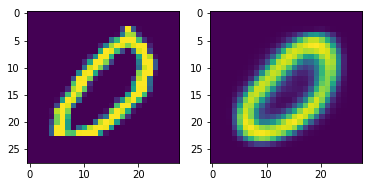

In [10]:
##########################
# Visualize reconstruction
##########################

def create_reconstruction(Q, P, data_loader, params):
    Q.eval()
    P.eval()
    X, label = get_X_batch(data_loader, params, size=1)

    
    ## Sampling from latent distribution
    
    z_mean, z_logvar = Q(X)
    std = z_logvar.mul(0.5).exp_() 
    if cuda:
       eps = torch.cuda.FloatTensor(std.size()).normal_()
    else:
       eps = torch.FloatTensor(std.size()).normal_()
    eps = Variable(eps)
    z_sample = eps.mul(std).add_(z_mean)
    
    
    ## Forwarding the mean of the latent distribution
    
    #z_mean, z_logvar = Q(X)
    #z_sample = z_mean
        
    x = P(z_sample)

    img_orig = np.array(X[0].data.tolist()).reshape(28, 28)
    img_rec = np.array(x[0].data.tolist()).reshape(28, 28)
    plt.subplot(1, 2, 1)
    plt.imshow(img_orig)
    plt.subplot(1, 2, 2)
    plt.imshow(img_rec)
    

data_loader = valid_loader    # Training data:  train_unlabeled_loader  |  Validation data:  valid_loader

create_reconstruction(Q_pt, P_pt, data_loader, params)   
plt.show()

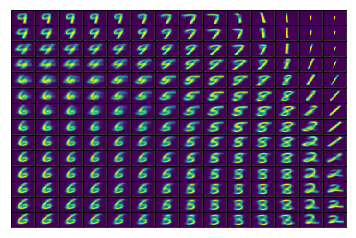

In [11]:
######################
# Visualize generation
######################

def grid_plot2d(Q, P, params):
    Q.eval()
    P.eval()

    cuda = params['cuda']
    
    z1 = Variable(torch.from_numpy(np.arange(-1, 1, 0.15).astype('float32')))
    z2 = Variable(torch.from_numpy(np.arange(-1, 1, 0.15).astype('float32')))
    
    if cuda:
        z1, z2 = z1.cuda(), z2.cuda()

    nx, ny = len(z1), len(z2)
    plt.subplot()
    gs = gridspec.GridSpec(nx, ny, hspace=0.05, wspace=0.05)

    for i, g in enumerate(gs):
        z = torch.cat((z1[i / ny], z2[i % nx])).resize(1, 2)
        x = P(z)

        ax = plt.subplot(g)
        img = np.array(x.data.tolist()).reshape(28, 28)
        ax.imshow(img, )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')

        
grid_plot2d(Q_pt, P_pt, params)
plt.show()

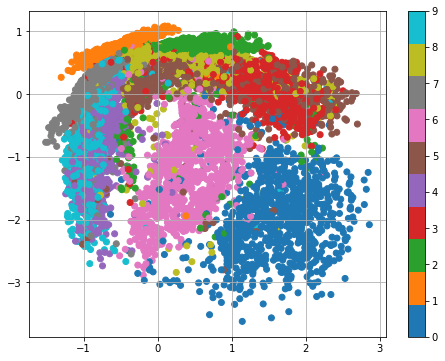

In [12]:
###############################
# Visualize latent distribution
###############################

Q_pt.eval()
P_pt.eval()

X, label = get_X_batch(data_loader, params, size=10000)
z_mean, z_logvar = Q_pt(X)

z_mean = np.array(z_mean.data.tolist())
label = np.array(label.data.tolist())
                
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mean[:,0], z_mean[:,1], c=label, cmap='tab10')
plt.colorbar()
plt.grid()
plt.show()

<hr>
<font size="4", color="RoyalBlue">
Now, remember the C-shaped distribution from the first notebook? Here it is again,
<img src="images/c_dist.png", width="300", align=”left”>
Can you learn a Variational Autoencoder that models this distribution.
</font>
<hr>

In [13]:
#####################################
# Reset workspace for next experiment
#####################################

%reset -f

In [1]:
##########################
# Import necessary modules
##########################

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
################
# Set parameters
################

cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

seed = 1

z_dim = 2
X_dim = 2
train_batch_size = 100
valid_batch_size = train_batch_size
N = 100
epochs = 100

params = {}
params['cuda'] = cuda
params['z_dim'] = z_dim
params['X_dim'] = X_dim
params['train_batch_size'] = train_batch_size
params['valid_batch_size'] = valid_batch_size
params['N'] = N
params['epochs'] = epochs


In [3]:
####################
# Define Data-loader
####################

def data_loader_Cdist(numSamples):

    z = np.random.randn(numSamples,2).astype(np.float32)        # Sample from Gaussian distribution
    z1 = z[:,0]
    z2 = z[:,1]
    os = 10
    ost = np.pi/2
    x1 = -(1.5*os+z1)*(np.sin(z2+ost))
    x2 = (os+z1)*np.cos(z2+ost)
    
    x = np.concatenate([np.expand_dims(x1,1),np.expand_dims(x2,1)],1)
    dummy = np.zeros(len(x))

    return torch.from_numpy(x), torch.from_numpy(dummy)

In [4]:
#################
# Define Networks
#################

# Encoder
class Q_net(nn.Module):
    def __init__(self):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        # Gaussian code (z)
        self.lin3gauss_mean = nn.Linear(N, z_dim)
        self.lin3gauss_logvar = nn.Linear(N, z_dim)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        xgauss_mean = self.lin3gauss_mean(x)
        xgauss_logvar = self.lin3gauss_logvar(x)

        return xgauss_mean, xgauss_logvar


# Decoder
class P_net(nn.Module):
    def __init__(self):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
        return x


In [5]:
###################
# Utility functions
###################


def save_model(model, filename):
    print('Best model so far, saving it...')
    torch.save(model.state_dict(), filename)


def report_loss(epoch, recon_loss):
    '''
    Print loss
    '''
    print('Epoch-{}; recon_loss: {:.4}'.format(epoch,recon_loss.data[0]))


In [6]:
####################
# Training procedure
####################

def train(P, Q, P_decoder, Q_encoder, data_loader):
    '''
    Train procedure for one epoch.
    '''
    TINY = 1e-15
    # Set the networks in train mode (apply dropout when needed)
    Q.train()
    P.train()

    # Loop through the labeled and unlabeled dataset getting one batch of samples from each
    # The batch size has to be a divisor of the size of the dataset or it will return
    # invalid samples
    for it in range(100):

        X, target = data_loader(train_batch_size)
        
        # Load batch and normalize samples to be 0-mean and unit-std
        X = (X + 4.55)/ 8.08
        X.resize_(train_batch_size, X_dim)
        X, target = Variable(X), Variable(target)
        if cuda:
            X, target = X.cuda(), target.cuda()

        # Init gradients
        P.zero_grad()
        Q.zero_grad()

        
        # Reconstruction phase
        
        z_mean, z_logvar = Q(X)
        std = z_logvar.mul(0.5).exp_()
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        z_sample = eps.mul(std).add_(z_mean)
        
        X_sample = P(z_sample)
        criterion = nn.MSELoss()
        criterion.size_average = False
        recon_loss = criterion(X_sample, X.resize(train_batch_size, X_dim))
        
        # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD_element = z_mean.pow(2).add_(z_logvar.exp()).mul_(-1).add_(1).add_(z_logvar)
        KLD_loss = torch.sum(KLD_element).mul_(-0.5)
        
        loss =  recon_loss + KLD_loss

        loss.backward()
        P_decoder.step()
        Q_encoder.step()

        P.zero_grad()
        Q.zero_grad()

    return recon_loss


def generate_model(train_labeled_loader, train_unlabeled_loader, valid_loader):
    torch.manual_seed(10)

    if cuda:
        Q = Q_net().cuda()
        P = P_net().cuda()
    else:
        Q = Q_net()
        P = P_net()

    # Set learning rates
    gen_lr = 0.0001

    # Set optimizators
    P_decoder = optim.Adam(P.parameters(), lr=gen_lr)
    Q_encoder = optim.Adam(Q.parameters(), lr=gen_lr)
    
    for epoch in range(epochs):
        #x,dummy = train_unlabeled_loader(train_batch_size)
        recon_loss = train(P, Q, P_decoder, Q_encoder,
                                                 train_unlabeled_loader)
        if epoch % 10 == 0:
            report_loss(epoch, recon_loss)

    return Q, P


In [7]:
##########################
# Train a generative model
##########################

Q, P = generate_model(data_loader_Cdist, data_loader_Cdist, data_loader_Cdist)

Epoch-0; recon_loss: 138.0
Epoch-10; recon_loss: 107.7
Epoch-20; recon_loss: 89.18
Epoch-30; recon_loss: 80.28
Epoch-40; recon_loss: 87.65
Epoch-50; recon_loss: 81.6
Epoch-60; recon_loss: 81.31
Epoch-70; recon_loss: 77.57
Epoch-80; recon_loss: 68.46
Epoch-90; recon_loss: 76.3


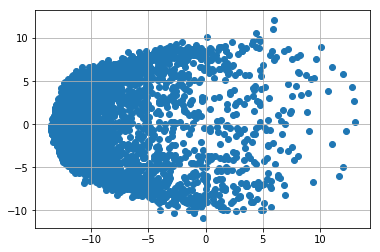

In [8]:
##################################
# Visualize generated distribution
##################################

def generate_Cdist(numSamples):

    z = np.random.randn(numSamples,2).astype(np.float32)        # Sample from Gaussian distribution
    
    z = Variable(torch.from_numpy(z))
    if cuda:
        z = z.cuda()
    
    x = P(z)

    return x

x = generate_Cdist(5000)
x = np.array(x.data.tolist())
x = x*8.08 - 4.55
x1 = x[:,0]
x2 = x[:,1]

plt.scatter(x1,x2)
plt.hold()
plt.grid(True)
plt.show()


<hr>
<font size="2", color="RoyalBlue">
The VAE seems to have done a near-decent job at modelling the C-shaped distribution. You can try and tune the VAE so that it models the distribution even better.
</font>
<hr>